# <center> Fake News Detector </center>

<B> Data set Information </B>

The dataset contains two types of articles fake and real news. This dataset was collected from real-world sources; the truthful articles were obtained by crawling articles from reuters.com (news 
website). As for the fake news articles, they were collected from different sources. The fake news 
articles were collected from unreliable websites that were flagged by Politifact (a fact-checking 
organization in the USA) and Wikipedia. The dataset contains different types of articles on different 
topics, however, the majority of articles focus on political and World news topics.

The dataset consists of two CSV files. The first file named “True.csv” contains more than 12,600 
articles from reuters.com. The second file named “Fake.csv” contains more than 12,600 articles from
different fake news outlet resources. Each article contains the following information: article title, text, 
type and the date the article was published on. To match the fake news data collected for kaggle.com, 
we focused mostly on collecting articles from 2016 to 2017. The data collected were cleaned and 
processed, however, the punctuations and mistakes that existed in the fake news were kept in the text.

## General Imports

In [37]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


import matplotlib.pyplot as plt


# For processing how well our methods have classified our data
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score,roc_auc_score


from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import itertools

from sklearn.linear_model import PassiveAggressiveClassifier

import pickle

[nltk_data] Downloading package stopwords to C:\Users\Bharadwaj
[nltk_data]     Satya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Helper Functions

### Confution Matrix

In [38]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Output

In [39]:
# FUNCTION Output
# Prints out the Scores of the model
def Output(pred,label_test):
    # Model Generalizability Analysis
    accuracy = accuracy_score(label_test, pred)
    conf_matrix = confusion_matrix(label_test, pred)
    F1Score = f1_score(label_test,pred)
    roc_auc = roc_auc_score(label_test,pred)
    recall = recall_score(label_test,pred)

    print('\033[1m' + 'Confusion Matrix' + '\033[0m') # printing in bold
    print(conf_matrix)
    
    print('\033[1m' + '\nRecall' + '\033[0m')
    print(recall)  

    print('\033[1m' + '\nAccuracy' + '\033[0m')
    print(accuracy)  
    
    print('\033[1m' + '\nF1 Score' + '\033[0m')
    print(F1Score)

    print('\033[1m' + '\nROC AUC Score' + '\033[0m')
    print(roc_auc)

## Data Cleaning

In [47]:
# create university of victoria dataframe

uv_true_df = pd.read_csv("uv_true.csv")
uv_true_df["label"] = 1

uv_fake_df = pd.read_csv("uv_fake.csv")
uv_fake_df["label"] = 0

uv_df = pd.concat([uv_true_df, uv_fake_df], axis = 0)
uv_df["author"] = np.nan

# uv_df.to_csv("uv_train.csv")
uv_true_df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [48]:
# merge kaggle dataset to university of victoria dataframe

kaggle_df = pd.read_csv("kaggle_train.csv")
kaggle_df["date"] = np.nan
kaggle_df["subject"] = np.nan

df = pd.concat([uv_df, kaggle_df], axis = 0)

# df.to_csv("train.csv")
kaggle_df.head()

,id,title,author,text,label,date,subject
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,NaN,NaN
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,NaN,NaN
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,NaN,NaN
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,NaN,NaN
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,NaN,NaN


In [6]:
# drop insignificant features
df = df.drop(['id', 'date', 'subject', 'author'], axis=1)

# drop null values from dataframe
df = df.dropna()
df.head()

,label,text,title
0,1,WASHINGTON (Reuters) - The head of a conservat...,"As U.S. budget fight looms, Republicans flip t..."
1,1,WASHINGTON (Reuters) - Transgender people will...,U.S. military to accept transgender recruits o...
2,1,WASHINGTON (Reuters) - The special counsel inv...,Senior U.S. Republican senator: 'Let Mr. Muell...
3,1,WASHINGTON (Reuters) - Trump campaign adviser ...,FBI Russia probe helped by Australian diplomat...
4,1,SEATTLE/WASHINGTON (Reuters) - President Donal...,Trump wants Postal Service to charge 'much mor...


In [7]:
X = df.drop('label',axis=1)
y = df['label']

In [8]:
# Reset Index
df.reset_index(inplace=True)
df.head()

,index,label,text,title
0,0,1,WASHINGTON (Reuters) - The head of a conservat...,"As U.S. budget fight looms, Republicans flip t..."
1,1,1,WASHINGTON (Reuters) - Transgender people will...,U.S. military to accept transgender recruits o...
2,2,1,WASHINGTON (Reuters) - The special counsel inv...,Senior U.S. Republican senator: 'Let Mr. Muell...
3,3,1,WASHINGTON (Reuters) - Trump campaign adviser ...,FBI Russia probe helped by Australian diplomat...
4,4,1,SEATTLE/WASHINGTON (Reuters) - President Donal...,Trump wants Postal Service to charge 'much mor...


## NLP

### Remove punctuation and Stop Words

In [9]:
# removes punctuation and stopwords

#def RemovePunctuationAndStopwords( ps = PorterStemmer(), corpus = [], df):
ps = PorterStemmer()
corpus = []

for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['title'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

### Bag of Words Model 

In [10]:
# create bag of words model and applying CountVectorizer
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()

In [11]:
# separate into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

## Machine Learning

### Multinomail NB Algorithm

In [12]:
classifier=MultinomialNB()

accuracy:   0.853
Confusion matrix, without normalization


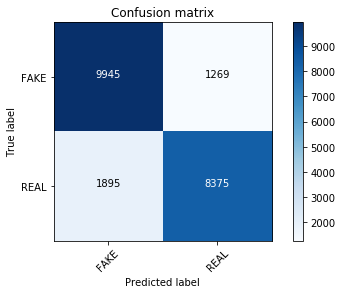

In [13]:
classifier.fit(X_train, y_train)
pred1 = classifier.predict(X_test)
score_MNBA = metrics.accuracy_score(y_test, pred1)
print("accuracy:   %0.3f" % score_MNBA)
cm = metrics.confusion_matrix(y_test, pred1)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [14]:
Scores1 = Output(pred1,y_test)
Scores1

Confusion Matrix
[[9945 1269]
 [1895 8375]]

Recall
0.8154819863680624

Accuracy
0.852727611245578

F1 Score
0.8411168022496736

ROC AUC Score
0.851159933793983


### Passive Aggressive Classifier Algorithm

In [15]:
linear_clf = PassiveAggressiveClassifier(n_iter_no_change=50)

accuracy:   0.855
Confusion matrix, without normalization


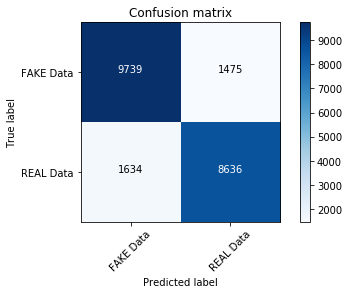

In [16]:
linear_clf.fit(X_train, y_train)
pred2 = linear_clf.predict(X_test)
score_PACA = metrics.accuracy_score(y_test, pred2)
print("accuracy:   %0.3f" % score_PACA)
cm = metrics.confusion_matrix(y_test, pred2)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

In [17]:
Scores2 = Output(pred2,y_test)
Scores2

Confusion Matrix
[[9739 1475]
 [1634 8636]]

Recall
0.8408958130477118

Accuracy
0.8552876559299945

F1 Score
0.8474559638879348

ROC AUC Score
0.8546818997466131


### Multinomial Classifier with Hyperparameter

In [18]:
classifier=MultinomialNB(alpha=0.1)

In [19]:
previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(X_train,y_train)
    y_pred=sub_classifier.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

Alpha: 0.0, Score : 0.852960342580525
Alpha: 0.1, Score : 0.8530068888475144
Alpha: 0.2, Score : 0.8530534351145038
Alpha: 0.30000000000000004, Score : 0.852960342580525
Alpha: 0.4, Score : 0.8532396201824614
Alpha: 0.5, Score : 0.8535654440513871
Alpha: 0.6000000000000001, Score : 0.8534258052504189
Alpha: 0.7000000000000001, Score : 0.853193073915472
Alpha: 0.8, Score : 0.852960342580525
Alpha: 0.9, Score : 0.8530068888475144


## Save Best working Algorithm

In [20]:
#Multinomail NB Algorithm
pickle.dump(classifier, 'MNBA_final_model.sav')

TypeError: file must have a 'write' attribute

In [ ]:
Pkl_Filename = "PAC.pkl"

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(linear_clf, file)
    
with open(Pkl_Filename, 'rb') as file:
    model = pickle.load(file)
    

Pickled_LR_Model

## Calculating Score of saved models

In [ ]:
"""
# Calculate the accuracy score and predict target values

# Calculate the Score 
score = Pickled_LR_Model.score(Xtest, Ytest)
# Print the Score
print("Test score: {0:.2f} %".format(100 * score))

# Predict the Labels using the reloaded Model
Ypredict = Pickled_LR_Model.predict(Xtest)

Ypredict

"""

## Rough

In [41]:
cv??

In [ ]:
uv_true_df = pd.read_csv("uv_true.csv")
uv_true_df["label"] = 1
uv_true_df.head()
uv_true_df["text"][0]

In [ ]:
uv_fake_df = pd.read_csv("uv_fake.csv")
uv_fake_df["label"] = 0
uv_fake_df.head()

In [ ]:
kaggle_df = pd.read_csv("train.csv")
kaggle_df.head(10)

## Predicting Output

In [22]:
def FND():
    input_title = input('\033[1m' + '\nEnter Title:' + '\033[0m')
    input_text = input('\033[1m' + '\nEnter Text:' + '\033[0m')
    
    data = {"title": [input_title], 
        "text":[input_text]}
    
    df = pd.DataFrame(data)
    
    df.reset_index(inplace=True)

    ps = PorterStemmer()
    corpus = []

    for i in range(0, len(df)):
        review = re.sub('[^a-zA-Z]', ' ', df['title'][i])
        review = review.lower()
        review = review.split()
        review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)
    
    print('\n')

    X = cv.transform(corpus).toarray()
    #print(X.shape)
    
    output = linear_clf.predict(X)
    #print(output)
    
    if output == 1:
         print('\033[1m' + '\nReal News Detected' + '\033[0m')
    
    else:
        print('\033[1m' + '\nFake News Detected' + '\033[0m')
    

In [27]:
FND()


Enter Title:He says Bigfoot is  real and his video proves it

Enter Text:Some people believe in ghosts. Others believe in aliens.   Hickory man Doug Teague believes in Bigfoot, and he claims  he had an encounter with the monstrous creature in the McDowell  County area on Aug. 16.Teague is part of the Bigfoot investigation  crew Catawba Valley Bigfoot Research.  At a Bigfoot information  session led by the Marion group Bigfoot 911 at the Hickory library in  2017, Bigfoot was described as a creature that walks on two legs like humans.  Bigfoot is said to grow to be 6 to 9 feet tall and weighs anything from 600 to  900 pounds.  Signs that Bigfoot might be nearby include wood knocking and rock  throwing, which is what Teague said he experienced in McDowell County  the other week.



Fake News Detected


In [28]:

FND()


Enter Title:Women's cricket | South Africa women take unassailable 3-1 lead

Enter Text:South Africa pulled together as a team, better in every department, to cruise past India by seven wickets in the fourth one-day international, and took an unbeatable 3-1 lead in the women’s cricket series at the Atal Bihari Vajpayee Ekana stadium on Sunday.  South Africa won the toss for the third time in the series and chased the highest target of 267 with remarkable composure. The top four batswomen shared the burden with half-centuries.  That put into shade the unbeaten 104 of Punam Raut and her century partnership with skipper Mithali Raj (45), who became the first woman in the world to score more 7,000 runs in one-dayers.  India took the field without strike bowler Jhulan Goswami, and had replaced opener Jemimah Rodrigues with Priya Punia who did well to score 32, after Smriti Mandhana fell early.



Real News Detected


In [29]:
#https://lastwordonsports.com/cricket/2021/03/13/the-top-5-best-finishers-in-world-cricket/
FND()


Enter Title:The top 5 best finishers in world cricket

Enter Text:In first place is England’s superstar, Jos Buttler. The right-hander has proved his credentials in all three formats of the game. His versatility in T20 cricket, sometimes plays against him because he is promoted to open. However, he is a sublime finisher towards the end of an innings, with the range of shots that he plays.  Buttler has the ability to scoop bowlers who nail their yorkers and can go deep in the crease to make full length deliveries, into balls that are in the slot. He has both the touch game and the power game to use when required.  Buttler averages nearly 40 at a strike rate of 110 while chasing and averages 40 at a strike rate of 126 when batting first. Both are quite ridiculous for ODI cricket standards. His 90 of just 51 balls against Pakistan at Trent Bridge in 2016, was an example of how his arrival can boost an already fast scoring rate.  Jos Buttler is currently the best finisher in world cricket

In [30]:
#https://www.forbes.com/sites/suzannerowankelleher/2021/02/25/faa-cant-explain-pilots-ufo-sighting-last-weekend-over-new-mexico/?sh=3019c6d449e1
FND()


Enter Title:FAA Can’t Explain Pilot’s UFO Sighting Last Weekend Over New Mexico

Enter Text:A radio transmission from an American Airlines from Cincinnati to Phoenix last weekend might have been ripped straight from the X-Files.  “Do you have any targets up here? We just had something go right over the top of us,” said the pilot at 1:19 p.m. CST on Sunday. “I hate to say this but it looked like a long cylindrical object that almost looked like a cruise missile type of thing moving really fast right over the top of us,” according to audio published on aviation blog Deep Black Horizon.  The blogger, Steve Douglass, intercepted the transmission accidentally as he was trying to pick up another aircraft with a radio scanner. “It was a pure coincidence,” he told The Arizona Republic.  Douglass used two flight tracking websites, Flightradar24 and Flight Aware, to determine that the exact position of the plane was “over the northeast corner of New Mexico west of Clayton, New Mexico” at an alt

In [31]:
FND()


Enter Title:North Korea 'not responding' to US contact efforts

Enter Text:US President Joe Biden's administration says it has been trying to contact the North Korean government since February but has yet to receive a response.  Washington had tried to reach Pyongyang in several different ways to prevent tensions escalating, officials said.  The US and North Korea remain at loggerheads over North Korea's nuclear and ballistic missile programmes.  Three meetings between Mr Biden's predecessor and North Korea's Kim Jong-un achieved little.  The talks failed to persuade North Korea to give up nuclear weapons - a key demand of the US and other Western powers.  North Korean state media has yet to acknowledge that Joe Biden is now the American president.  US attempts to communicate with Pyongyang have included the "New York Channel" - through the North Korean mission at the United Nations.  A US official told Reuters news agency there had been "multiple attempts" to engage with North Korea,

In [42]:
FND()


Enter Title:'Perhaps Kohli, Shastri think he is Dhoni's replacement': Sehwag feels management needs to back Rishabh Pant more

Enter Text:India vs England: Sehwag believes that  \perhaps the team management, comprising  captain Virat Kohli and head coach Ravi  Shastri, is looking for a like-for-like  replacement for MS Dhoni in Pant, which  the former India opening batsman reckons,  is not the right way forward.Despite the  recent string of impressive performances,  former India batsman Virender Sehwag is  worried that Pant could be subjected to  an ouster from the team if he doesn't  score in the coming two three matches.  Sehwag compared the current generation  of cricketers to the time he played,  explaining how the room for inconsistency  today is far narrower, and that Pant is  bound to play such shots time and again,  which is where the management needs to back  him and give him a longer run.



Fake News Detected


In [43]:
FND()


Enter Title:'Perhaps Kohli, Shastri think he is Dhoni's replacement': Sehwag feels management needs to back Rishabh Pant more

Enter Text:India vs England: Sehwag believes that  perhaps the team management, comprising  captain Virat Kohli and head coach Ravi  Shastri, is looking for a like-for-like  replacement for MS Dhoni in Pant, which  the former India opening batsman reckons,  is not the right way forward.Despite the  recent string of impressive performances,  former India batsman Virender Sehwag is  worried that Pant could be subjected to  an ouster from the team if he doesn't  score in the coming two three matches.  Sehwag compared the current generation  of cricketers to the time he played,  explaining how the room for inconsistency  today is far narrower, and that Pant is  bound to play such shots time and again,  which is where the management needs to back  him and give him a longer run.



Fake News Detected


In [44]:
FND()


Enter Title:Duke University undergrads ordered to stay in place all week as Covid-19 cases spike

Enter Text:Duke University officials issued a stay-in-place order for all undergraduate students through next Sunday as the school tries to combat a rapidly escalating number of Covid-19 cases.  In a letter sent to students on Saturday, officials at the Durham, North Carolina, university said that more than 180 students have tested positive for Covid-19 and are in isolation, while another 200 are under in quarantine based on contact tracing. The spike in cases is "principally driven by students attending recruitment parties for selective living groups," the letter said. This is the largest one-week total of positive cases and quarantines since the pandemic began, officials said. All courses will shift to remote learning and students living on campus must stay in their room or apartment at all times outside of essential activities, such as getting food or for health or safety reasons. Off-

In [45]:
FND()


Enter Title:US election 2020: Why Donald Trump lost

Enter Text:Donald Trump won more than 70 million votes, the second highest total in American history. Nationally, he has more than a 47% share of his vote, and looks to have won 24 states, including his beloved Florida and Texas.  He has an extraordinary hold over large swathes of this country, a visceral connection that among thousands of supporters has brought a near cult-like devotion. After four years in the White House, his supporters studied the fine print of his presidency and clicked enthusiastically on the terms and conditions.  Any analysis of his political weakness in 2020 also has to acknowledge his political strength. However, he was defeated, becoming one of only four incumbents in the modern era not to get another four years. Also he has become the first president to lose the popular vote in consecutive elections.  Live updates with reaction and analysis Five reasons Biden won the election Donald Trump won the preside

In [46]:
type(cv)

sklearn.feature_extraction.text.CountVectorizer

In [49]:
FND()


Enter Title:FAA Can’t Explain Pilot’s UFO Sighting Last Weekend Over New Mexico

Enter Text:A radio transmission from an American Airlines from Cincinnati to Phoenix last weekend might have been ripped straight from the X-Files.  “Do you have any targets up here? We just had something go right over the top of us,” said the pilot at 1:19 p.m. CST on Sunday. “I hate to say this but it looked like a long cylindrical object that almost looked like a cruise missile type of thing moving really fast right over the top of us,” according to audio published on aviation blog Deep Black Horizon.  The blogger, Steve Douglass, intercepted the transmission accidentally as he was trying to pick up another aircraft with a radio scanner. “It was a pure coincidence,” he told The Arizona Republic.  Douglass used two flight tracking websites, Flightradar24 and Flight Aware, to determine that the exact position of the plane was “over the northeast corner of New Mexico west of Clayton, New Mexico” at an alt